# Сравнение экономических показателей и качества жизни в разных странах

### Цели
1. Выяснить, зависит ли качество жизни в стране от её абсолютного или относительного богатства (на душу населения).
2. Выделить группы стран со схожими условиями жизни.

### Используемые даные
Группа компаний World Bank Group занимается поддержкой развивающихся стран и собирает множество данных со всех источников об экономической и не только ситуации во всём мире. Данные взяты из World Data Bank и представляют собой огромный набор индикаторов (более тысячи) по всем страннам за несколько десятков лет.

По разныим индикатором данные представлены за разный период и не всегда по всем странам, поэтому иногда анализ ограничавается только доступными годами.

Загрузка данных происходит через API сервисов Data Catolog и World Bank.

Сначала импорт всех библиотек:

In [1]:
import requests
import json
import pandas as pd
import os.path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# и сразу небольшая настройка
# сохранять ли нужные для презентации графики
save_plots_to_file = False

# стили графиков из seaborn
sns.set_style()
sns.set_theme()
if save_plots_to_file:
    plt.style.use("dark_background")

Нужные данные:

In [2]:
# данные содержат много ';' и ',', поэтому разделитель - '::'
csv_delimiter = "::"

# индикаторы для загрузки
# пары (*полная строка из indicators.csv*, *короткое название*)
raw_indicators = [
    ("GDP (current US$)::NY.GDP.MKTP.CD::0", "GDP"),
    ("GDP per capita (constant 2015 US$)::NY.GDP.PCAP.KD::0", "GDP per capita"), # fix 2010 to 2015 (error in csv)
    ("Inflation, consumer prices (annual %)::FP.CPI.TOTL.ZG::0", "inflation"),
    ("Unemployment, total (% of total labor force) (modeled ILO estimate)::SL.UEM.TOTL.ZS::0", "unemployment"),
    ("Educational attainment, at least Bachelor's or equivalent, population 25+, total (%) (cumulative)::SE.TER.CUAT.BA.ZS::0", "educational attainment"),
    ("Government expenditure on education, total (% of government expenditure)::SE.XPD.TOTL.GB.ZS::0", "education expenditure"),
    ("Domestic general government health expenditure (% of general government expenditure)::SH.XPD.GHED.GE.ZS::0", "health expenditure"),
    ("GNI per capita, Atlas method (current US$)::NY.GNP.PCAP.CD::0", "GNI per capita"),
    ("Life expectancy at birth, total (years)::SP.DYN.LE00.IN::0", "life expectancy"),
    ("Birth rate, crude (per 1,000 people)::SP.DYN.CBRT.IN::0", "birth rate"),
    ("Death rate, crude (per 1,000 people)::SP.DYN.CDRT.IN::0", "death rate"),
    ("Suicide mortality rate (per 100,000 population)::SH.STA.SUIC.P5::0", "suicide mortality rate"),
    ("Goods imports (BoP, current US$)::BM.GSR.MRCH.CD::0", "goods imports"),
    ("Service imports (BoP, current US$)::BM.GSR.NFSV.CD::0", "services imports"),
    ("Goods exports (BoP, current US$)::BX.GSR.MRCH.CD::0", "goods exports"),
    ("Service exports (BoP, current US$)::BX.GSR.NFSV.CD::0", "services exports"),
    ("Imports of goods and services (current US$)::NE.IMP.GNFS.CD::0", "total imports"),
    ("Exports of goods and services (current US$)::NE.EXP.GNFS.CD::0", "total exports"),
    ("Population, total::SP.POP.TOTL::0", "population"),
    ("People using at least basic drinking water services (% of population)::SH.H2O.BASW.ZS::0", "basic water services"),
    ("Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)::SH.ALC.PCAP.LI::0", "alcohol consumption"),
    ("School enrollment, primary (% gross)::SE.PRM.ENRR::0", "primary school enrollment"),
    ("School enrollment, secondary (% gross)::SE.SEC.ENRR::0", "secondary school enrollment"),
    ("School enrollment, tertiary (% gross)::SE.TER.ENRR::0", 'tertiary school enrollment'),
    ("PM2.5 air pollution, population exposed to levels exceeding WHO guideline value (% of total)::EN.ATM.PM25.MC.ZS::0", "air pollution")
]

# получаем список кодов индикаторов для загрузки
indicators = list(map(lambda x: x[0].split(csv_delimiter)[1], raw_indicators))

Определим функции для получения списка индикаторов и загрузки данных через API:

In [3]:
# вспомогательная функция
def download_json(url: str, filepath: str):
    """Загрузить JSON по адресу `url` и записать в файл по пути `filepath`, также озвращает результат в виде строки"""
    dataset_request = requests.get(
        url,
        stream=True,
    )
    # запись байтов в файл
    with open(filepath, "wb") as file:
        for chunk in dataset_request.iter_content(chunk_size=128):
            file.write(chunk)
    # чтение загруженного json
    with open(filepath, "rt") as file:
        res = json.load(file)
    return res


def download_indicators_list():
    """Загрузить полный список индикаторов датасета WDI и записать в файл `indicators.csv`"""
    dataset_id = "0037712"  # World Development Indicators ID

    with open("indicators.csv", "wt") as indicators_file:
        print("name", "id", "load", sep=csv_delimiter, file=indicators_file)
        # получить информацию о датасете
        dataset_url = f"https://datacatalogapi.worldbank.org/ddhxext/DatasetView?dataset_unique_id={dataset_id}"
        dataset_metadata_path = f"datasets_metadata/{dataset_id}.json"
        indicators = download_json(dataset_url, dataset_metadata_path)
        # получить информацию о каждом индикаторе
        for indicator in indicators["Indicator"]:
            # парсим адрес
            name = indicator.split("::")[0]
            id = indicator.split("=")[-1]
            print(name, id, sep=csv_delimiter, file=indicators_file)


def get_indicators_data(indicators: list[str]):
    """Загрузить данные индикаторов"""
    # основной датасет
    df = pd.DataFrame(columns=["country", "date"])
    for id in indicators:
        json_path = f"indicators/json/{id}.json"
        csv_path = f"indicators/csv/{id}.csv"
        # пропустить уже загруженные
        if os.path.exists(csv_path):
            print(id, "is already loaded")
        else:
            url = f"https://api.worldbank.org/v2/country/all/indicator/{id}?per_page=20000&format=json"
            print("Downloading", id)
            data = download_json(url, json_path)
            # проверить, что данные найдены (некоторые индикаторы удалены и возникает ошибка)
            if len(data) != 2:
                print(f"Not found {id}")
                continue
            # записать в виде csv
            with open(csv_path, "wt") as csv_file:
                name = data[1][0]["indicator"]["value"]
                print("country", "date", name, sep=csv_delimiter, file=csv_file)
                for row in data[1]:
                    country = row["country"]["value"]
                    date = row["date"]
                    value = row["value"]
                    print(country, date, value, sep=csv_delimiter, file=csv_file)

        # считать индикатор
        new = pd.read_csv(csv_path, delimiter=csv_delimiter, engine="python")
        # удалить NaN
        new.dropna(how="any", inplace=True)
        # добавить к основному датасету
        df = pd.merge(left=df, right=new, how="outer", on=("country", "date"))

    return df

Загрузим список индикаторов (для удобства) и данные самих индикаторов из списка `indicators`, используя созданные функции:

In [4]:
download_indicators_list()
raw_df = get_indicators_data(indicators)

NY.GDP.MKTP.CD is already loaded
NY.GDP.PCAP.KD is already loaded
FP.CPI.TOTL.ZG is already loaded
SL.UEM.TOTL.ZS is already loaded
SE.TER.CUAT.BA.ZS is already loaded
SE.XPD.TOTL.GB.ZS is already loaded
SH.XPD.GHED.GE.ZS is already loaded
NY.GNP.PCAP.CD is already loaded
SP.DYN.LE00.IN is already loaded
SP.DYN.CBRT.IN is already loaded
SP.DYN.CDRT.IN is already loaded
SH.STA.SUIC.P5 is already loaded
BM.GSR.MRCH.CD is already loaded
BM.GSR.NFSV.CD is already loaded
BX.GSR.MRCH.CD is already loaded
BX.GSR.NFSV.CD is already loaded
NE.IMP.GNFS.CD is already loaded
NE.EXP.GNFS.CD is already loaded
SP.POP.TOTL is already loaded
SH.H2O.BASW.ZS is already loaded
SH.ALC.PCAP.LI is already loaded
SE.PRM.ENRR is already loaded
SE.SEC.ENRR is already loaded
SE.TER.ENRR is already loaded
EN.ATM.PM25.MC.ZS is already loaded


In [5]:
# информация о датасете
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16930 entries, 0 to 16929
Data columns (total 27 columns):
 #   Column                                                                                                Non-Null Count  Dtype  
---  ------                                                                                                --------------  -----  
 0   country                                                                                               16930 non-null  object 
 1   date                                                                                                  16930 non-null  int64  
 2   GDP (current US$)                                                                                     13979 non-null  float64
 3   GDP per capita (constant 2015 US$)                                                                    13963 non-null  float64
 4   Inflation, consumer prices (annual %)                                                               

Переименуем столбцы для удобства работы (на их короткие названия):

In [6]:
replace_rules = {
    i[0].split(csv_delimiter)[0]: i[1] for i in raw_indicators
}

for a, b in replace_rules.items():
    if a in raw_df.columns:
        raw_df[b] = raw_df[a]
        raw_df.drop(columns=[a], inplace=True)

In [7]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16930 entries, 0 to 16929
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   country                      16930 non-null  object 
 1   date                         16930 non-null  int64  
 2   GDP                          13979 non-null  float64
 3   GDP per capita               13963 non-null  float64
 4   inflation                    11004 non-null  float64
 5   unemployment                 7752 non-null   float64
 6   educational attainment       1332 non-null   float64
 7   education expenditure        4537 non-null   float64
 8   health expenditure           4504 non-null   float64
 9   GNI per capita               12385 non-null  float64
 10  life expectancy              16124 non-null  float64
 11  birth rate                   16300 non-null  float64
 12  death rate                   16282 non-null  float64
 13  suicide mortalit

### Отбор стран для анализа
Исходные данные содержат записи по регионам в целом, поэтому проще составить список стран, которые войдут в анализ. Также сразу выберем временной период с 1995 по 2023 год.

In [8]:
# список стран
include_regions = np.array(
    [
        "Afghanistan",
        "Albania",
        "Algeria",
        "American Samoa",
        "Andorra",
        "Angola",
        "Antigua and Barbuda",
        "Argentina",
        "Armenia",
        "Aruba",
        "Australia",
        "Austria",
        "Azerbaijan",
        "Bahamas, The",
        "Bahrain",
        "Bangladesh",
        "Barbados",
        "Belarus",
        "Belgium",
        "Belize",
        "Benin",
        "Bermuda",
        "Bhutan",
        "Bolivia",
        "Bosnia and Herzegovina",
        "Botswana",
        "Brazil",
        "British Virgin Islands",
        "Brunei Darussalam",
        "Bulgaria",
        "Burkina Faso",
        "Burundi",
        "Cabo Verde",
        "Cambodia",
        "Cameroon",
        "Canada",
        "Cayman Islands",
        "Central African Republic",
        "Chad",
        "Channel Islands",
        "Chile",
        "China",
        "Colombia",
        "Comoros",
        "Congo, Dem. Rep.",
        "Congo, Rep.",
        "Costa Rica",
        "Cote d'Ivoire",
        "Croatia",
        "Cuba",
        "Curacao",
        "Cyprus",
        "Czechia",
        "Denmark",
        "Djibouti",
        "Dominica",
        "Dominican Republic",
        "Ecuador",
        "Egypt, Arab Rep.",
        "El Salvador",
        "Equatorial Guinea",
        "Eritrea",
        "Estonia",
        "Eswatini",
        "Ethiopia",
        "Faroe Islands",
        "Fiji",
        "Finland",
        "France",
        "French Polynesia",
        "Gabon",
        "Gambia, The",
        "Georgia",
        "Germany",
        "Ghana",
        "Gibraltar",
        "Greece",
        "Greenland",
        "Grenada",
        "Guam",
        "Guatemala",
        "Guinea",
        "Guinea-Bissau",
        "Guyana",
        "Haiti",
        "Honduras",
        "Hong Kong SAR, China",
        "Hungary",
        "Iceland",
        "India",
        "Indonesia",
        "Iran, Islamic Rep.",
        "Iraq",
        "Ireland",
        "Isle of Man",
        "Israel",
        "Italy",
        "Jamaica",
        "Japan",
        "Jordan",
        "Kazakhstan",
        "Kenya",
        "Kiribati",
        "Korea, Dem. People's Rep.",
        "Korea, Rep.",
        "Kosovo",
        "Kuwait",
        "Kyrgyz Republic",
        "Lao PDR",
        "Latvia",
        "Lebanon",
        "Lesotho",
        "Liberia",
        "Libya",
        "Liechtenstein",
        "Lithuania",
        "Luxembourg",
        "Macao SAR, China",
        "Madagascar",
        "Malawi",
        "Malaysia",
        "Maldives",
        "Mali",
        "Malta",
        "Marshall Islands",
        "Mauritania",
        "Mauritius",
        "Mexico",
        "Micronesia, Fed. Sts.",
        "Moldova",
        "Monaco",
        "Mongolia",
        "Montenegro",
        "Morocco",
        "Mozambique",
        "Myanmar",
        "Namibia",
        "Nauru",
        "Nepal",
        "Netherlands",
        "New Caledonia",
        "New Zealand",
        "Nicaragua",
        "Niger",
        "Nigeria",
        "North Macedonia",
        "Northern Mariana Islands",
        "Norway",
        "Oman",
        "Pakistan",
        "Palau",
        "Panama",
        "Papua New Guinea",
        "Paraguay",
        "Peru",
        "Philippines",
        "Poland",
        "Portugal",
        "Puerto Rico",
        "Qatar",
        "Romania",
        "Russian Federation",
        "Rwanda",
        "Samoa",
        "San Marino",
        "Sao Tome and Principe",
        "Saudi Arabia",
        "Senegal",
        "Serbia",
        "Seychelles",
        "Sierra Leone",
        "Singapore",
        "Sint Maarten (Dutch part)",
        "Slovak Republic",
        "Slovenia",
        "Solomon Islands",
        "Somalia",
        "South Africa",
        "South Sudan",
        "Spain",
        "Sri Lanka",
        "St. Kitts and Nevis",
        "St. Lucia",
        "St. Martin (French part)",
        "St. Vincent and the Grenadines",
        "Sudan",
        "Suriname",
        "Sweden",
        "Switzerland",
        "Syrian Arab Republic",
        "Tajikistan",
        "Tanzania",
        "Thailand",
        "Timor-Leste",
        "Togo",
        "Tonga",
        "Trinidad and Tobago",
        "Tunisia",
        "Turkiye",
        "Turkmenistan",
        "Turks and Caicos Islands",
        "Tuvalu",
        "Uganda",
        "Ukraine",
        "United Arab Emirates",
        "United Kingdom",
        "United States",
        "Uruguay",
        "Uzbekistan",
        "Vanuatu",
        "Venezuela, RB",
        "Viet Nam",
        "Virgin Islands (U.S.)",
        "West Bank and Gaza",
        "Yemen, Rep.",
        "Zambia",
        "Zimbabwe",
    ],
    dtype=object,
)

# годы, которые будут включены в датасет
start_year = 1995
end_year = 2023

# выбор только нужных стран и лет
cleared_df = raw_df[raw_df["country"].isin(include_regions)][raw_df["date"] >= start_year][raw_df["date"] <= end_year]

C:\Users\redun\AppData\Local\Temp\ipykernel_101684\175727770.py:230: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleared_df = raw_df[raw_df["country"].isin(include_regions)][raw_df["date"] >= start_year][raw_df["date"] <= end_year]
C:\Users\redun\AppData\Local\Temp\ipykernel_101684\175727770.py:230: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cleared_df = raw_df[raw_df["country"].isin(include_regions)][raw_df["date"] >= start_year][raw_df["date"] <= end_year]


Для отбора стран будем использовать 2 главных показателя:
- Показатель ВВП (GDP, Gross Domestic Product, внутренний валовой продукт) - это макроэкономический показатель, который отражает стоисмость всех товаров и услуг произведённых за календарный год.
- Показатель ВВП на душу населения (GDP per capita) - ВВП в пересчсёте на одного гражданина государства.

В соответствии с первой целью выберем 2 группы стран, деление производится по показателю ВВП и ВВП на душу населения за 2023 год. То есть считается, что страна с высоким абсолютным ВВП богата *абсолютно*, а страна с высоким ВВП на душу населения богата *относительно*.
- 1 группа - страны с высоким ВВП
- 2 группа - страны с высоким ВВП на душу населения

In [9]:
# число стран в каждой группе
N = 7

# выбор стран для каждой группы
top_absolute_GDP_countries = (
    cleared_df[cleared_df["date"] == end_year]
    .sort_values("GDP", ascending=False)[:N]["country"]
    .reset_index(drop=True)
)
top_GDP_per_capita_countries = (
    cleared_df[cleared_df["date"] == end_year]
    .sort_values("GDP per capita", ascending=False)[:N]["country"]
    .reset_index(drop=True)
)

In [10]:
print(
    f"Top {N} countries by GDP (group 1):",
    top_absolute_GDP_countries,
    f"Top {N} countries by GDP per capite (group 2):",
    top_GDP_per_capita_countries,
    sep="\n",
)

Top 7 countries by GDP (group 1):
0     United States
1             China
2           Germany
3             Japan
4             India
5    United Kingdom
6            France
Name: country, dtype: object
Top 7 countries by GDP per capite (group 2):
0       Luxembourg
1          Ireland
2      Switzerland
3           Norway
4        Singapore
5    United States
6        Australia
Name: country, dtype: object


Таким образом, в первую группу вошли:
- США
- Китай
- Япония
- Индия
- Великобритания
- Франция

Во вторую группу:
- Люксембург
- Ирландия
- Швейцария
- Норвегия
- Сингапур
- США
- Австралия

Примечательно, что США вошли сразу в обе группы.

In [11]:
# создадим новый датафрейм только с отобранными странами
df = cleared_df[
    cleared_df["country"].isin(
        pd.concat([top_absolute_GDP_countries, top_GDP_per_capita_countries])
    )
].sort_values(
    "date", ascending=True
)
# метка о группе
df["group"] = df["country"].isin(top_GDP_per_capita_countries) + 1

### решение проблемы со странами, вошедшими сразу в 2 списка
to_duplicate = df[df["country"].isin(top_absolute_GDP_countries)][
    df["country"].isin(top_GDP_per_capita_countries)
]
to_duplicate["group"] = 1
df = pd.concat([df, to_duplicate])

C:\Users\redun\AppData\Local\Temp\ipykernel_101684\2428190239.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  to_duplicate = df[df["country"].isin(top_absolute_GDP_countries)][


Полученный датасет:

In [85]:
df

,country,date,GDP,GDP per capita,inflation,unemployment,educational attainment,education expenditure,health expenditure,GNI per capita,...,total imports,total exports,population,basic water services,alcohol consumption,primary school enrollment,secondary school enrollment,tertiary school enrollment,air pollution,group
13496,United States,1995,7.639749e+12,41710.820725,2.805420,5.650,NaN,15.889874,NaN,29040.0,...,9.025720e+11,8.128100e+11,2.662780e+08,NaN,NaN,105.278030,94.229439,79.440460,44.694454,2
12538,Switzerland,1995,3.528358e+11,67264.911294,1.799828,3.094,NaN,14.785625,NaN,46700.0,...,1.278411e+11,1.412039e+11,7.040687e+06,NaN,NaN,95.419182,100.889610,32.363091,95.100249,2
4876,China,1995,7.344848e+11,1520.029469,16.791225,3.000,NaN,NaN,NaN,540.0,...,1.199008e+11,1.318588e+11,1.204855e+09,NaN,NaN,111.240463,48.663631,4.673590,100.000000,1
11705,Singapore,1995,8.781254e+10,30379.899114,1.720534,3.300,7.560000,18.889408,NaN,23630.0,...,1.443097e+11,1.590469e+11,3.524506e+06,NaN,NaN,NaN,NaN,NaN,100.000000,2
6272,France,1995,1.601095e+12,29745.128729,1.796481,11.834,NaN,10.500997,NaN,25740.0,...,3.366014e+11,3.622145e+11,5.954366e+07,NaN,NaN,108.470047,111.132141,51.348160,99.625354,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13472,United States,2019,2.152140e+13,61330.645977,1.812210,3.669,36.055153,15.517134,22.453348,66200.0,...,3.116954e+12,2.538450e+12,3.283300e+08,99.744631,9.57,100.981300,100.063431,87.888710,NaN,1
13471,United States,2020,2.132295e+13,59394.778327,1.233584,8.055,37.520000,12.654216,22.600342,64690.0,...,2.776503e+12,2.150112e+12,3.315269e+08,99.820422,9.90,100.305794,100.509819,87.567657,NaN,1
13470,United States,2021,2.359403e+13,62741.001813,4.697859,5.349,35.049229,NaN,21.408550,71330.0,...,3.408277e+12,2.550038e+12,3.320490e+08,99.894938,NaN,98.305489,101.192490,84.855087,NaN,1
13469,United States,2022,2.574411e+13,63720.764161,8.002800,3.650,37.660000,NaN,NaN,76590.0,...,3.966165e+12,2.995046e+12,3.332714e+08,99.964113,NaN,96.971733,97.473488,79.361931,NaN,1


### Анализ показателей
Далее будет представлено много графиков и диаграмм, поэтому сначала подготовим словарь цветов и удобный объект-генератор для получения следующего цвета:

In [15]:
# словарь цветов
my_colors = {
    "blue": "#0A84FF",
    "green": "#30D158",
    "red": "#FF453A",
    "orange": "#FF9F0A",
    "pink": "#FF375F",
    "purple": "#BF5AF2",
    "yellow": "#FFD60A",
    "cyan": "#64D2FF",
    "brown": "#AC8E68"
}

# добавление цвета в зависимости от темы
if save_plots_to_file:
    my_colors['white'] = '#FFFFFF'
else:
    my_colors['black'] = "#000000"

# список цветов
colors = list(my_colors.values())

# создание объекта генератора для получения следующего цвета
def color_gen_f():
    c = 0
    while 1:
        yield colors[c]
        c = (c + 1) % len(colors)

color_gen = color_gen_f()

#### Графики ВВП по отобранным странам
Построим графики ВВП и ВВП на душу населения по отобранным странам (для каждой группы свой показатель). Для удобства зададим функцию:

In [13]:
def plot_GDP(attributes, filename):
    plt.figure("GDP", figsize=(10, 5))

    for i in range(2):
        axis = plt.subplot(1, 2, i + 1)
        plt.title(attributes[i])
        for country, series in df[df["group"] == i + 1].groupby(["country"]):
            axis = series.plot(
                x="date",
                y=attributes[i],
                label=country[0],
                xlabel="Год",
                ylabel=attributes[i],
                ax=axis,
                color=next(color_gen)
            )

    plt.tight_layout()
    if save_plots_to_file:
        plt.savefig(f"pics/{filename}.png", transparent=True)
    plt.show()

Теперь построим график:

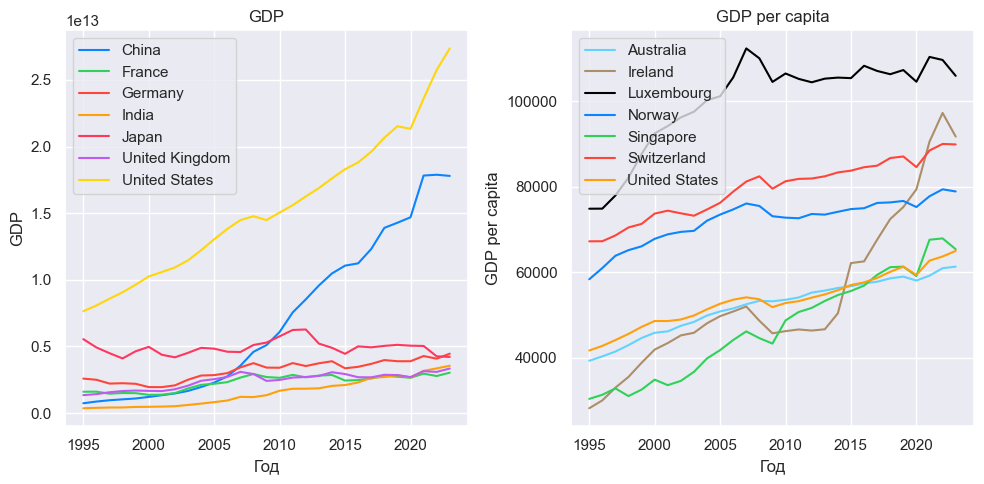

In [16]:
plot_GDP(["GDP", "GDP per capita"], "GDP 1")

Также наоборот, чтобы сравнить показатели между группами:

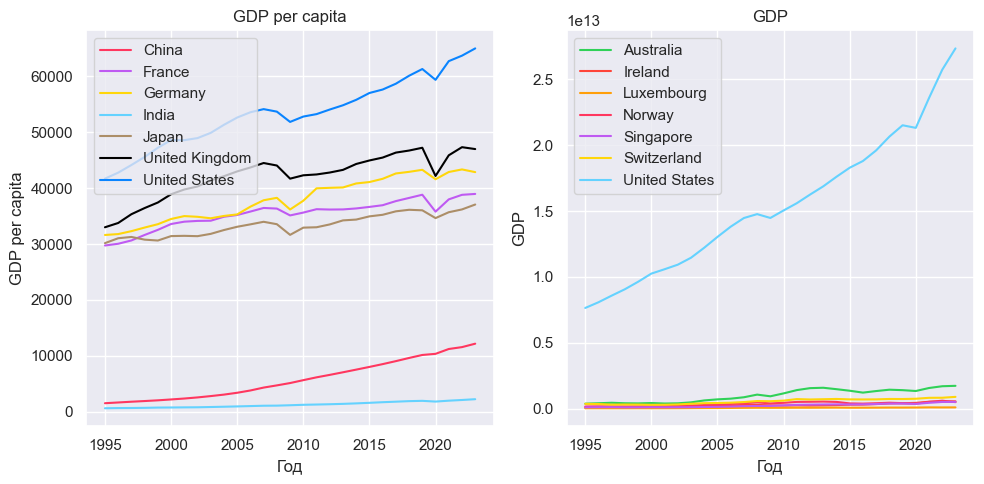

In [17]:
plot_GDP(["GDP per capita", "GDP"], "GDP 2")

Отсюда можно вынести следующие суждения:
- Абсолютный ВВП в странах второй группы очень мал по сравнению с ВВП в странах первой группы.
- В странах второй группы ВВП на душу населения растёт значительно быстрее, чем в странах первой группы, где рост умеренный.

#### Инфляция и безработица
Сравним показатели инфляции и безработицы - одни из самых важных показателей при оценке экономической ситуации в государстве.

Зададим функцию построения графика, чтобы избежать дублирования кода:

In [18]:
def plot_bar_timeseries(attribute, filename, ylim=None):
    fig = plt.figure(attribute, figsize=(10, 5))

    axis = plt.subplot()
    plt.title(attribute)

    means = (
        df.groupby(["date", "group"])
        .aggregate({attribute: "mean"})
        .unstack(level=1)
    )
    axis = means.plot(
        kind="bar",
        ylabel=attribute + ", %",
        rot=45,
        xlabel="Year",
        ax=axis,
        color=[my_colors['red'], my_colors['green']],
        width=0.74,
    )
    if ylim:
        axis.set_ylim(0, ylim)
    plt.legend(labels=["group 1", "group 2"])

    plt.tight_layout()
    if save_plots_to_file:
        plt.savefig(f"pics/{filename}.png", transparent=True)
    plt.show()

Построим график инфляции:

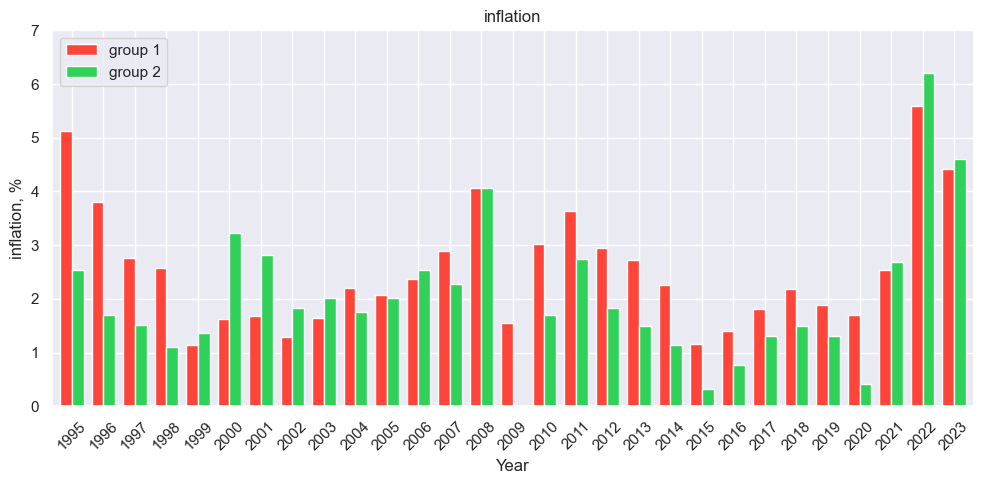

In [19]:
plot_bar_timeseries('inflation', 'inflation', 7)

По графику видно, что большую часть лет в странах первой группы инфляция на 1-2 п.п. выше, чем в странах второй группы. Это говорит о большей экономической стабильности в странах второй группы, так как их валюты обесцениваются медленнее и цены на товары и услуги соответственно растут медленнее.

Также заметны резкие скачки в 2000-2001 и 2008 годах, они приходятся на мировые экономические кризисы.

Теперь построим график безработицы:

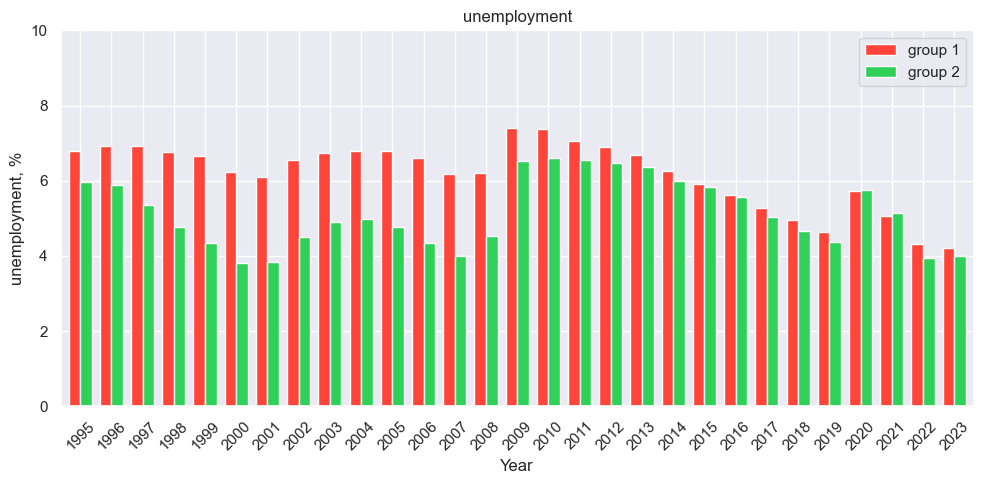

In [20]:
plot_bar_timeseries('unemployment', 'unemployment', 10)

Наблюдается похожая картина: до 2012 года в странах первой группы была большая доля безработицы среди работоспособного населения, позже ситуация уравнялась в обеих группах. Это можно объяснить тем, что в больших государствах первой группы правительству сложнее обеспечить рабочими местами всё население. Возможно, за последнее десятилетие ситуация улучшилась благодаря развитию информационно-телекоммуникационных технологий и частичному переходу на удалённые рабочие места.

#### Международная торговля
Рассмотрим несколько важных показателей, характеризующих государство как члена международных торговых отношений: экспорт и импорт товаров и услуг.

Имеются данные об объёме торговли в номинальной стоимости в долларах, переведём объёмы экспорта и импорта товаров и услуг в доли от общего объёма торгов каждой страны в процентах:

In [21]:
for i in ["goods imports", 'services imports']:
    df[i] = df[i] / df['total imports'] * 100
for i in ["goods exports", 'services exports']:
    df[i] = df[i] / df['total exports'] * 100

Напишем функцию для отрисовки 2 круговых диаграмм (чтобы не дублировать код):

In [22]:
def plot_barcharts(attributes, title, filename):
    figure = plt.figure(title, figsize=(9, 5))

    pie_df = (
        df[df["date"] == end_year]
        .groupby(["group"])
        .aggregate({attr: "mean" for attr in attributes})
        .reset_index()
        .transpose()
    )

    for j in range(2):
        axis = plt.subplot(1, 2, j + 1)
        axis.set_title(f'Group {j + 1}')
        axis.pie(
            x=pie_df[j].drop(index="group"),
            autopct="%1.1f%%",
            labels=pie_df.drop(index="group").index,
            colors=[my_colors['blue'], my_colors['green']]
    )

    if save_plots_to_file:
        plt.savefig(f"pics/{filename}.png", transparent=True)
    plt.show()

Построим диаграмму состава импорта для обеих групп:

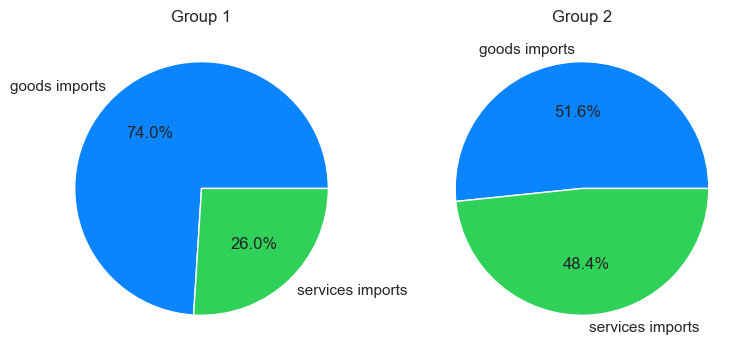

In [23]:
plot_barcharts(["goods imports", "services imports"], "Imports", 'imports')

И диаграмму состава экспорта:

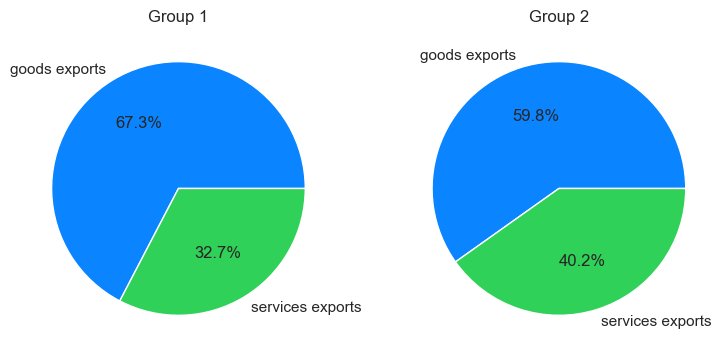

In [24]:
plot_barcharts(["goods exports", "services exports"], "Exports", 'exports')

На диаграммах отчётливо видно, что в странах второй группы доля услуг в торговле значительно выше, чем в странах первой группы. Это говорит о том, что страны второй группы менее сосредоточены на производстве и промышленности. Стоит так же учесть тот факт, что в странах второй группы более развиты финансовый и бизнес-сектора. Например, Швейцария из второй группы оказывает банковский услуги странам по всему миру, а Сингапур - один из самых крупных мировых бизнес-центров. В то время как страны первой группы получают значительную часть доходов от продажи ресурсов и товаров промышленности.

#### Численность населения
Посмотрим, какую численность населения имеют страны обеих групп. Представим эту информацию в виде таблицы:

In [25]:
df[df["date"] == end_year][["country", "group", "population"]].sort_values(
    ["group", "population"], ascending=[True, False]
)

,country,group,population
7385,India,1,1.428628e+09
4848,China,1,1.410710e+09
13468,United States,1,3.349149e+08
7915,Japan,1,1.245166e+08
6525,Germany,1,8.448227e+07
13404,United Kingdom,1,6.835000e+07
6244,France,1,6.817023e+07
13468,United States,2,3.349149e+08
3225,Australia,2,2.663854e+07
12510,Switzerland,2,8.849852e+06


Во всех странах первой группы население на 2-3 порядка больше, чем в странах второй группы. Такие результаты ожидаемы, учитывая во сколько раз абсолютный ВВП стран первой группы выше и насколько они крупнее.

#### Средний годовой доход граждан
Рассмотрим показатель GNI per capita (Gross National Income) - общий национальный доход на душу населения, он совпадает со средним доходом граждан за год. Используем функцию, с помощью которой строили график ВВП:

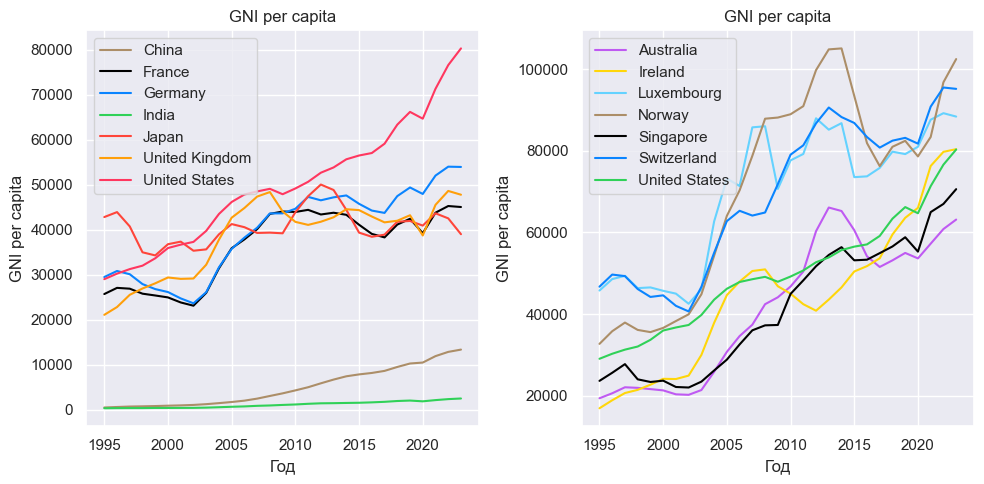

In [26]:
plot_GDP(["GNI per capita", "GNI per capita"], 'GNI')

На этих графиках заметна динамика во времени, в обеих группах этот показатель растёт, но во второй группе рост происходит быстрее.

Теперь сравним группы между собой (средние данные за последние 3 года):

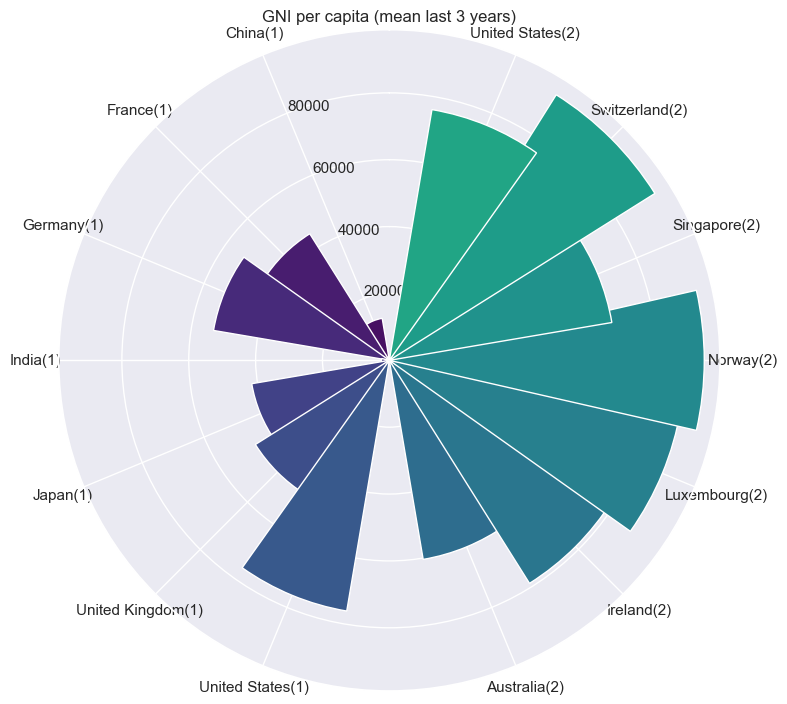

In [28]:
plt.figure("GNI", figsize=(8, 8))

attribute = "GNI per capita"

axis = plt.subplot(projection='polar')


n_last_years = 3

means = (
    df[df["date"] > end_year - n_last_years]
    .groupby(["country", 'group'])
    .aggregate({attribute: "mean"})
    .reset_index()
    .sort_values(['group', 'country'])
)


n = len(means)
step = 2 * np.pi / (n + 2)
angles = np.arange(step, np.pi, step)
angles = np.concatenate([angles, angles + np.pi])
means['angles'] = angles
means['labels'] = means['country'] + '(' + means['group'].map(str) + ')'

axis.bar(
    x=means['angles'],
    width=2*np.pi/n,
    height=means['GNI per capita'],
    tick_label=means['labels'],
    color=plt.cm.viridis(angles / 10.),
)
axis.set_theta_offset(np.pi/2)
plt.title(f'GNI per capita (mean last {n_last_years} years)')

plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/GNI-round.png", transparent=True)
plt.show()

На этом графике уже отчётливо видно, насколько средний доход граждан в странах второй группы превосходит этот же показатель в странах первой группы. Причём разброс между странами во второй группе так же меньше.

#### Рождаемость и смертность
Оценим рождаемост и смертность во всех отобранных странах - это важные демографические показатели, говорящие о том, сколько родившихся/умерших приходится на каждую 1000 человек.

Отобразим эти данные на горизонтальном столбчатом графике и найдём средние значения по группам (последние данные за 2022 год):

In [31]:
# отрицание значений, чтобы правильно отобразить на графике
df["death rate"] = -df["death rate"]

Mean birth rate in 1 group: 9.962428571428573
Mean birth rate in 2 group: 10.057142857142855
Mean death rate in 1 group: 10.106285714285715
Mean death rate in 2 group: 7.7142857142857135


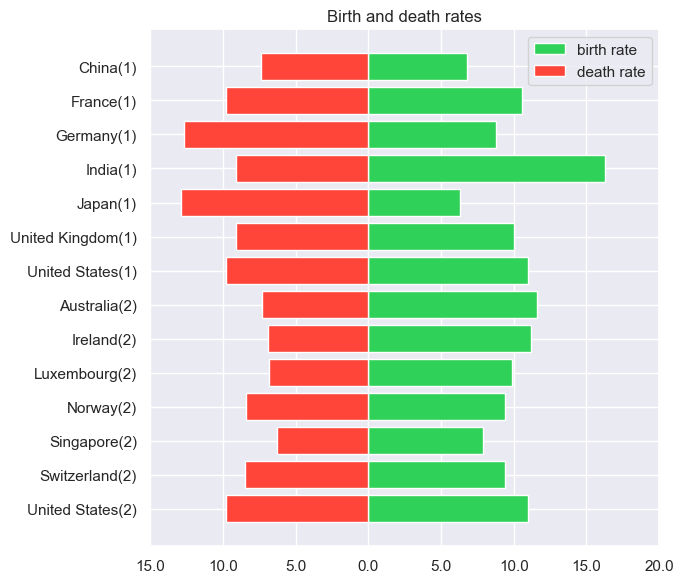

In [32]:
### Рождаемость и смертность
attributes = ["birth rate", "death rate"]

figure = plt.figure("Life expectancy", figsize=(7, 6))

axis = plt.subplot()

for i in range(2):
    data = (
        df[df["date"] == 2022][["country", "group", attributes[i]]]
        .sort_values(["group", "country"], ascending=False)
        .reset_index(drop=True)
    )
    data["labels"] = data["country"] + "(" + data["group"].map(str) + ")"
    for j in range(2):
        print(
            f"Mean {attributes[i]} in {j + 1} group:",
            abs(data[data["group"] == j + 1][attributes[i]].mean()),
        )
    axis.barh(
        y=data["labels"],
        width=data[attributes[i]],
        color=[my_colors['green'], my_colors['red']][i]
    )

plt.legend(labels=attributes)
plt.xticks(ticks=plt.xticks()[0], labels=map(lambda x: str(abs(x)), plt.xticks()[0]))
plt.title("Birth and death rates")
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/birth-and-death-rates.png", transparent=True)
plt.show()

Стоит выделить высокую смертность в Германии и Японии (их можно объяснить высокой степенью загрязнения воздуха) и высокую рождаемость в Индии.

Средние показатели рождаемости в обеих группах примерно равны, а средняя смертность в первой группе значительно выше. Из-за такого соотношения показателей в странах первой группы со временем может наблюдаться естесвенная убыль населения.

#### Ожидаемая продолжительность жизни
Этот показатель говорит о том, какого среднего возраста достигнут родившиеся сейчас дети по оценкам учёных.

Построим столбчатую диаграмму по всем отобранным странам (последние данные за 2022 год):

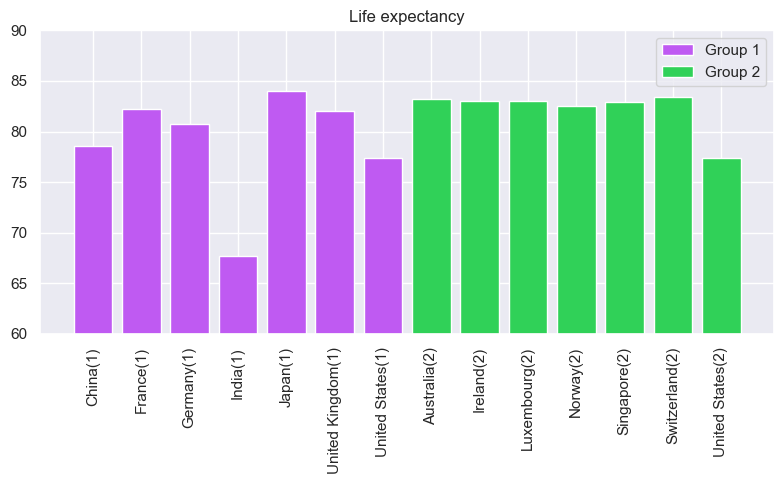

In [34]:
figure = plt.figure("Life expectancy", figsize=(8, 5))

axis = plt.subplot()

data = df[df["date"] == 2022][["country", "group", "life expectancy"]].sort_values(
    ["group", "country"]
).reset_index(drop=True)
data["labels"] = data["country"] + "(" + data["group"].map(str) + ")"
n = len(data)

axis.bar(
    x=data['labels'],
    height=data[data['group'] == 1]['life expectancy'].to_list() + [0] * (n // 2),
    color=my_colors['purple']
)
axis.bar(
    x=data['labels'],
    height=[0] * (n // 2) + data[data['group'] == 2]['life expectancy'].to_list(),
    color=my_colors['green'],
)
plt.xticks(rotation=90)
plt.ylim(60, 90)
plt.legend(labels=['Group 1', 'Group 2'])
plt.title('Life expectancy')
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/life-expectancy.png", transparent=True)
plt.show()

Ярко выражена стабильность прогнозов в странах второй группы - все они находятся на уровне 83-84 лет (исключение - США, также входящшие в первую группу). В странах первой группы картина нечёткая - оценки сильно колеблются, достигая возраста ниже 70 лет в Индии.

То есть в среднем в странах второй группы ожидаемая продолжительность жизни значительно выше, что говорит о существовании целой совокупности благоприятных факторов, повлиявших на такую оценку.

#### Медицина и образование
Рассмотрим, как государства в разных группах финансово поддерживают медицину и образование - одни из важнейших областей жизни человека.

Для этого используем данные о том, какая часть государственного финансирования приходится на эти сферы, и построим круговые диаграммы (последние данные за 2021 год):

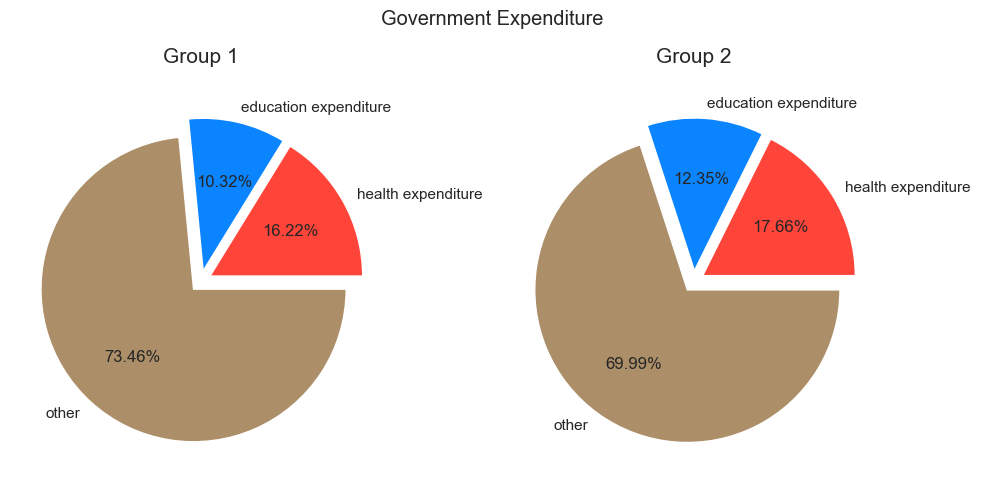

In [50]:
# извлекаем нужные данные и представляем в удобном виде
expenditure_data = (
    df[df["date"] == 2021][
        ["country", "health expenditure", "education expenditure", "group"]
    ]
    .sort_values(["group", "country"])
    .groupby(["group"])
    .aggregate({"health expenditure": "mean", "education expenditure": "mean"})
    .reset_index()
    .set_index("group")
    .transpose()  # можно обращаться по номеру группы как по индексу (1 или 2)
)

fig = plt.figure("Expenditure", (10, 5))

for i in range(2):
    values = expenditure_data[i + 1].to_list()
    labels = expenditure_data.index.to_list()

    values.append(100 - sum(values))
    labels.append("other")

    axis = plt.subplot(1, 2, i + 1)

    axis.pie(
        x=values,
        labels=labels,
        explode=[0.07, 0.07, 0.07], autopct="%.2f%%",
        colors=[
            my_colors['red'],
            my_colors['blue'],
            my_colors['brown']
        ]
    )
    axis.set_title(f"Group {i + 1}", fontdict={'fontsize': 15}, pad=20)


fig.suptitle("Government Expenditure")
plt.tight_layout()
if save_plots_to_file:
    plt.savefig("pics/expenditure.png", transparent=True)
plt.show()

В целом эти показатели несильно отличаются между группами(хотя и во второй группе финансирование данных сфер на 1.5-2% выше), поэтому нельзя сделать однозначных выводов.

На этом моменте возникли трудности с поиском подходящих индикаторов в датасете, поэтому дальнейшее сравнение более поверхностное и носит ознакомительный характер.

***P.S.** Низкая значимость следующих показателей далее подтверждается использованием алгоритмов уменьшения размерности, которые опускают их как малозначимые.*

#### Разные сравнения
Для удобства будем использовать следующую функцию для построения столбчатого графика одного индикатора по всем выбранным странам:

In [51]:
def short_describe(indicator, date=end_year):
    data = df[df["date"] == date][
        ["country", indicator, "group"]
    ].sort_values(["group", indicator])
    data.plot(
        kind="bar",
        x="country",
        y=indicator,
        color=[my_colors["purple"]] * N + [my_colors["green"]] * N,
        legend=False
    )
    print(data.groupby(["group"]).agg({indicator: "mean"}))

##### Доля людей с высшим образованием
Показатель говорит о том, сколько граждан старше 25 лет имеют степень бакалавра и выше.

Наиболее полные данные представлены за 2020 год:

       educational attainment
group                        
1                   24.224111
2                   36.166173


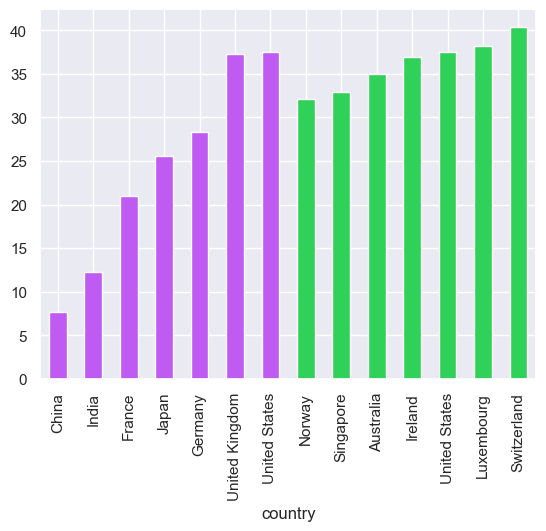

In [55]:
short_describe('educational attainment', 2020)

В странах второй группы значительно более высокий уровень людей с высшим образованим (24% против 36%)

##### Количество самоубийств
Наиболее полные данные за 2019 год:

       suicide mortality rate
group                        
1                   12.314286
2                   12.428571


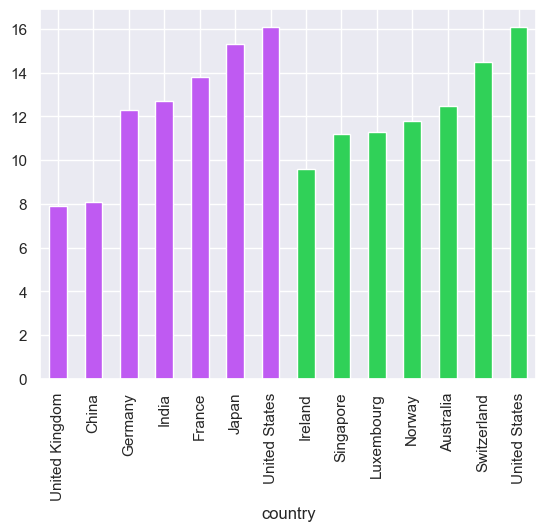

In [56]:
short_describe("suicide mortality rate", 2019)

Уровни примерно совпадают в обеих группах, поэтому нельзя сделать выводов о каких-либо зависимостях.

##### Доступ к системе водоснабжения с **питьевой** водой

Наиболее полные данные за 2022 год:

       basic water services
group                      
1                 98.578125
2                 99.401600


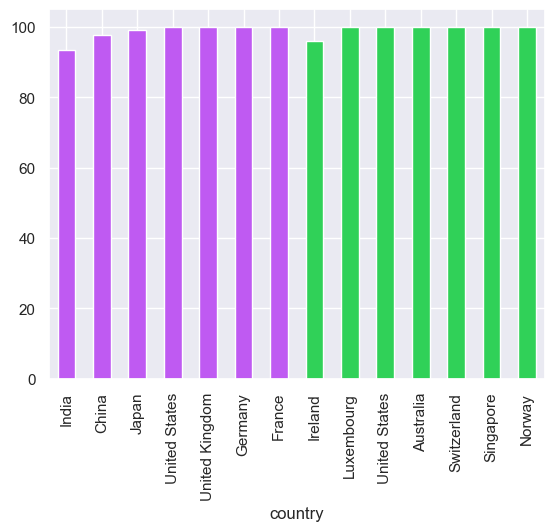

In [58]:
short_describe("basic water services", 2022)

Удивительно, что в обе группы попали страны, в которых не все жители имеют прямой доступ к питьевой воде, такая серьёзная проблема до сих пор остаётся нерешённой и в достаточно развитых государствах.

##### Потребление алкоголя (л/год на человека)
Наиболее полные даные за 2020 год:

       alcohol consumption
group                     
1                 8.264286
2                 8.720000


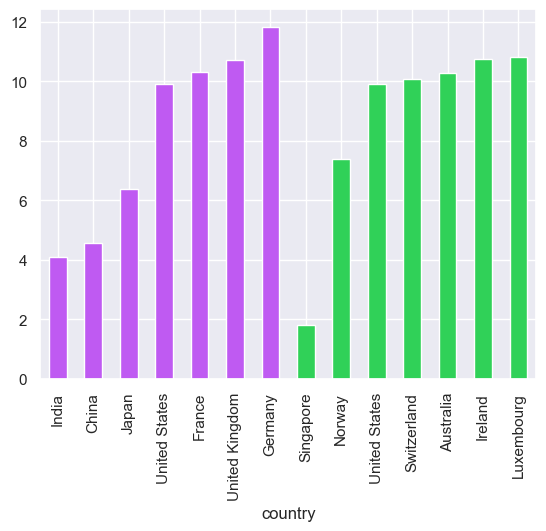

In [62]:
short_describe("alcohol consumption", 2020)

Количество потребляемого алкоголя оказалось одинаковым в обеих группах (если не учитывать, что какая-то часть продаж алкоголя может оставаться незафиксированной).

##### Доля людей, пошедших в школу


Этот показатель рассчитывается как отношение количества людей, пошедших в школу, к количеству людей, которые по возрасту соответстсвуют данной ступени образования. Поэтому он иногда превышает 100% - это не ошибка.


       primary school enrollment
group                           
1                     101.443231
2                     100.196191


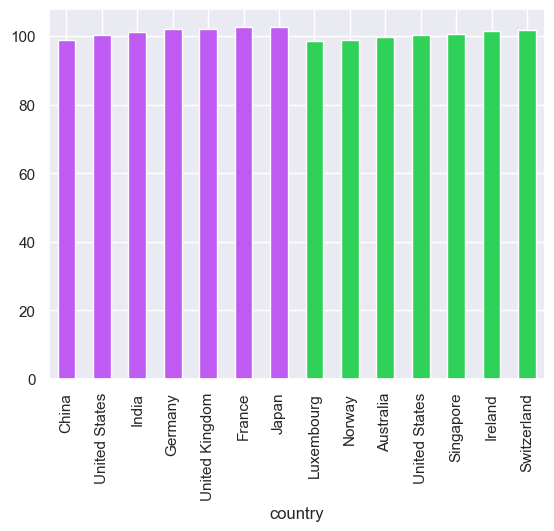

In [63]:
short_describe("primary school enrollment", 2020)

В выбранных странах все дети начали получение начального школьного образования.

#### Доля людей, продолживших получение образования после школы
Аналогичный прошлому показатель для второй ступени образования.

       secondary school enrollment
group                             
1                       100.251299
2                       115.379561


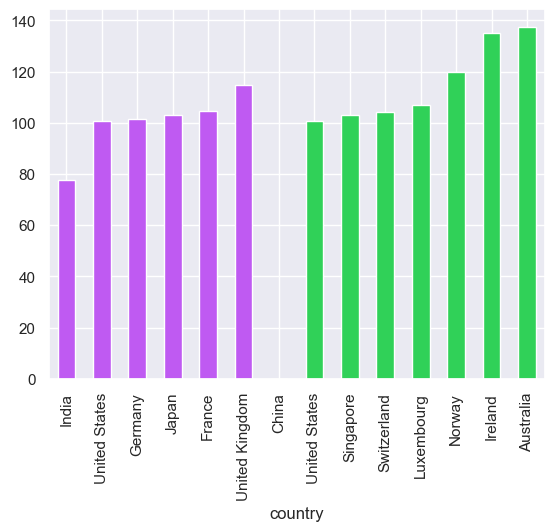

In [64]:
short_describe("secondary school enrollment", 2020)

Можно заметить экстремально высокие значение в странах второй группы, которые могут свидетельствовать о том, что многие люди решили продолжить образование через какое-то время после окончания школы.

#### Доля людей, поступивших в высшие учебные заведения
Аналогичный показатель для высшего образования.

       tertiary school enrollment
group                            
1                       64.650094
2                       77.245647


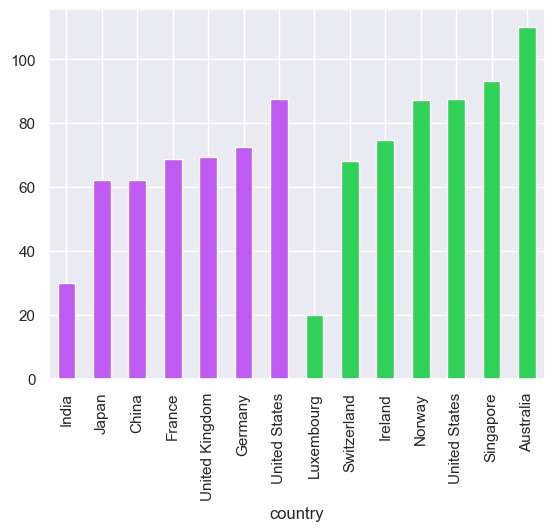

In [65]:
short_describe("tertiary school enrollment", 2020)

В этом случае ситуации схожие, но во второй группе в среднем большая доля людей решает получить высшее образование (65% против 77%). 

##### Загрязнение возхдуха
Важный показатель, характеризующий, какая доля населения живёт в условиях превышения норм выбросов, установленных ВОЗ.

Последние полные данные за 2017 год:

       air pollution
group               
1          73.432020
2          35.518635


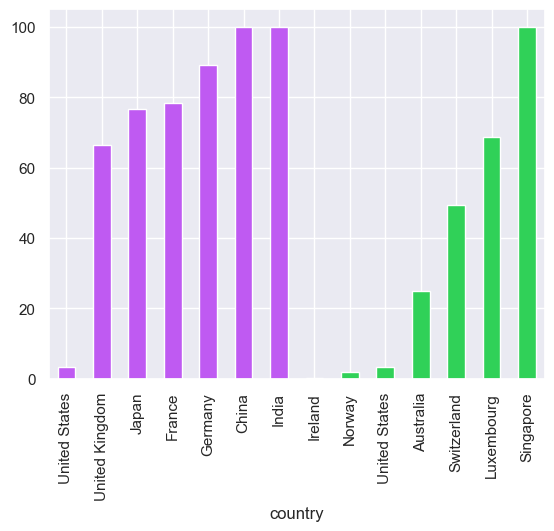

In [69]:
short_describe("air pollution", 2017)

В странах первой группы и некоторые странах второй группы этот показатель достигают 100%. такими результатами можно объяснить маленькую продолжительность жизни и высокую смертность в этих странах.

#### Промежуточные выводы
На основе проанализированных индикаторов, можно сделать вывод, что уровнь жизни в стране действительно зависит от её богатства, но не конкретно от абсолютного или относительного, а от обоих одновременно. В маленьких странах с высоким ВВП на душу населения могут быть лучшие условия жизни за счёт того, что такие государства обычно маленькие и их правительствам проще контролировать и развивать сразу все сферы жизни людей, будь то образование, медицина или экологическая обстановка. Они так же более гибки в удовлетворении своих потребностей благодаря более развитым торговых отношениям, но даже с учётом всех этих нюансов уровень жизни в странах обеих исследуемых групп оказался примерно одинаковым для обычных граждан.

### Кластеризация для разбиения стран на группы
Для достижения второй цели используем методы машинного обучения и математической статистики.

Кластеризация - это одна из задач машинного обучения (без учителя), суть которой заключается в разбиении немаркированных данных на несколько непересекающихся классов. Похожие по своим характеристикам объекты попадают в одну группу.

Используем алгоритм K-Means (его реализацию из библиотеки `sklearn`) для разбиения всех стран на 5 групп (число подобрано эмпирически) на основе всех признаков, которые были рассмотрены вручную выше. Этот алгоритм разбивает данные на группы, используя функцию расстояния между объектами (наиболее близкие окажутся в одной группе). По принципу работы он похож на алгоритм классфикации KNN (k-nearest neighbors).

In [89]:
from sklearn.cluster import KMeans

# некоторые столбцы для удаления (мешают разбиению)
columns_to_drop = [
    "date",
    "total exports",
    "total imports",
    "goods exports",
    "goods imports",
    "services exports",
    "services imports",
]

# количество групп
n_clusters = 5

# выбор данных и удаление NaN
data = cleared_df[cleared_df["date"] == 2017].drop(columns=columns_to_drop).fillna(0)
data.set_index("country", inplace=True)
x = data.to_numpy()

# обучение на данных
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(x)

clustered = data.copy()

# присвоение классов
clustered["cluster"] = kmeans.predict(x)

# вывод стран по группам
for i in range(n_clusters):
    print(f"Cluster {i}:", clustered[clustered["cluster"] == i].index.to_list())

Cluster 0: ['Afghanistan', 'Albania', 'Algeria', 'American Samoa', 'Andorra', 'Angola', 'Antigua and Barbuda', 'Argentina', 'Armenia', 'Aruba', 'Austria', 'Azerbaijan', 'Bahamas, The', 'Bahrain', 'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bermuda', 'Bhutan', 'Bolivia', 'Bosnia and Herzegovina', 'Botswana', 'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Cayman Islands', 'Central African Republic', 'Chad', 'Channel Islands', 'Chile', 'Colombia', 'Comoros', 'Congo, Dem. Rep.', 'Congo, Rep.', 'Costa Rica', "Cote d'Ivoire", 'Croatia', 'Cuba', 'Curacao', 'Cyprus', 'Czechia', 'Denmark', 'Djibouti', 'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt, Arab Rep.', 'El Salvador', 'Equatorial Guinea', 'Estonia', 'Eswatini', 'Ethiopia', 'Faroe Islands', 'Fiji', 'Finland', 'French Polynesia', 'Gabon', 'Gambia, The', 'Georgia', 'Ghana', 'Greece', 'Greenland', 'Grenada', 'Guam', 'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyan

c:\Users\redun\anaconda3\envs\mlmethods\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


Заметно, что это разбиение по группам очень сильно напоминает классификацию стран по уровню развития общества. Самые отстающие страны, то есть большинство стран африки и некоторые островные государства, попали в одну группу. Уже перешедшие к пост-индустриальному (информационному) обществу США и Китай вовсе попали в отдельные группы. Страны, которые ещё находятся где-то посередине, разбились на две группы:
- Более прогрессивные Франция, Германия, Япония, Велкобритания и (неожиданно) Индия
- Все остальные (Австралия, Бразилия, Канада, Россия и т.д.).

### PCA
PCA (principal component analysis, метод главных компонент) - это один из способов уменьшения размерности пространства признаков для выявления наиболее значимых из них и уменьшения объёма информации при сохранении ценности.

Уменьшим размерность пространства показателей, чтобы выявить наиболее значимые из них.

In [90]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5).fit(data)
pca_res = pca.transform(data)

n_pcs = pca.components_.shape[0]

most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]

features = pca.feature_names_in_

print(
    "The most important indicators:", ", ".join([features[i] for i in most_important])
)

The most important indicators: GDP, population, GDP per capita, GNI per capita, secondary school enrollment


Наиболее важными по результатами PCA оказались показатели:
- ВВП
- население
- ВВП на душу населения
- средний доход на душу населения
- доля поступления на второй уровень образования

Попадание первых 4 показателей в этот список можно объяснить их высоким размахов по миру (алгоритм K-Means добивается наименьшей дисперсии внутри групп), в то время как попадание последнего индикатора в этот список достаточно неожиданно.

***P.S.** До удаления из данных столбцов с объёмами импорта и экспорта в этот список попадали именно они.*

# Выводы

В ходе работы были получены практические навыки анализа данные, в том числе опыт получения данных из открытых источников, их обработки и преобразования, визуализации, использования методов машинного обучения для анализа данных.
Были также достигнуты поставленные цели:
- Проведено сравнение стран между собой и сделаны выводы об уровне жизни в исследуемых группах.
- Страны были разбиты на группы с помощью алгоритма кластеризации и были выявлены наиболее значимые признаки.